In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Set the random seed
np.random.seed(42)

# Load the data
data = pd.read_csv('solar_irradiance.csv')
data['Latitude'] = data['Latitude'].str.rstrip('°').astype(float)
data['Longitude'] = data['Longitude'].str.rstrip('°').astype(float)

# Extract features and target
features = data[['Month', 'Hour', 'Latitude', 'Longitude', 'Panel_Capacity(W)', 'Panel_Efficiency', 'Wind_Speed(km/h)', 'Cloud_Cover(%)', 'temperature (°f)']]
target = data['Irradiance(W/m^2)']

In [6]:
# One-hot encode categorical features
encoder = OneHotEncoder(sparse=False, categories='auto')
categorical_features = features[['Month', 'Hour']]
encoded_categorical_features = encoder.fit_transform(categorical_features)

# Get the feature names after encoding
encoded_feature_names = encoder.get_feature_names_out(['Month', 'Hour'])

# Create a DataFrame with the encoded categorical features
encoded_categorical_features_df = pd.DataFrame(encoded_categorical_features, columns=encoded_feature_names)

# Scale the numerical features
scaler = StandardScaler()
scaled_numerical_features = scaler.fit_transform(features[['Latitude', 'Longitude', 'Panel_Capacity(W)', 'Panel_Efficiency', 'Wind_Speed(km/h)', 'Cloud_Cover(%)', 'temperature (°f)']])

# Combine encoded categorical and scaled numerical features
processed_features = np.concatenate((encoded_categorical_features_df, scaled_numerical_features), axis=1)

# Reshape the features to match the LSTM input shape
reshaped_features = np.reshape(processed_features, (processed_features.shape[0], 1, processed_features.shape[1]))

D:\python\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(1, processed_features.shape[1])))
model.add(Dense(1))

# Compile and train the model
model.compile(loss='mse', optimizer='adam')
model.fit(reshaped_features, target, epochs=120)

#Saving the model
# model.save('solar_irradiance_model.h5')

Epoch 1/120
9/9 [==============================] - 2s 3ms/step - loss: 50375.5469
Epoch 2/120
9/9 [==============================] - 0s 3ms/step - loss: 50355.4570
Epoch 3/120
9/9 [==============================] - 0s 2ms/step - loss: 50333.7852
Epoch 4/120
9/9 [==============================] - 0s 2ms/step - loss: 50311.2500
Epoch 5/120
9/9 [==============================] - 0s 2ms/step - loss: 50284.2344
Epoch 6/120
9/9 [==============================] - 0s 2ms/step - loss: 50252.4766
Epoch 7/120
9/9 [==============================] - 0s 2ms/step - loss: 50215.5859
Epoch 8/120
9/9 [==============================] - 0s 2ms/step - loss: 50169.2422
Epoch 9/120
9/9 [==============================] - 0s 2ms/step - loss: 50113.9219
Epoch 10/120
9/9 [==============================] - 0s 2ms/step - loss: 50044.9805
Epoch 11/120
9/9 [==============================] - 0s 2ms/step - loss: 49970.8203
Epoch 12/120
9/9 [==============================] - 0s 2ms/step - loss: 49876.4570
Epoch 13/120


Epoch 100/120
9/9 [==============================] - 0s 2ms/step - loss: 6845.8223
Epoch 101/120
9/9 [==============================] - 0s 2ms/step - loss: 6641.5225
Epoch 102/120
9/9 [==============================] - 0s 2ms/step - loss: 6434.9307
Epoch 103/120
9/9 [==============================] - 0s 2ms/step - loss: 6243.6646
Epoch 104/120
9/9 [==============================] - 0s 2ms/step - loss: 6044.2236
Epoch 105/120
9/9 [==============================] - 0s 2ms/step - loss: 5869.3174
Epoch 106/120
9/9 [==============================] - 0s 2ms/step - loss: 5705.4961
Epoch 107/120
9/9 [==============================] - 0s 2ms/step - loss: 5521.8853
Epoch 108/120
9/9 [==============================] - 0s 2ms/step - loss: 5362.3413
Epoch 109/120
9/9 [==============================] - 0s 2ms/step - loss: 5208.1074
Epoch 110/120
9/9 [==============================] - 0s 2ms/step - loss: 5060.9604
Epoch 111/120
9/9 [==============================] - 0s 2ms/step - loss: 4907.2051
Epoc

In [8]:
# Load the saved model
from keras.models import load_model
loaded_model = load_model('solar_irradiance_model.h5')

# Function to predict the irradiance for a given month, hour, and other features
def predict_irradiance(month, hour, latitude, longitude, panel_capacity, panel_efficiency, wind_speed, cloud_cover, temperature):
    # Encode the month and hour
    encoded_month_hour = encoder.transform([[month, hour]])
    # Scale the numerical features
    scaled_features = scaler.transform([[latitude, longitude, panel_capacity, panel_efficiency, wind_speed, cloud_cover, temperature]])
    # Combine encoded categorical and scaled numerical features
    processed_features = np.concatenate((encoded_month_hour, scaled_features), axis=1)
    # Reshape the features to match the LSTM input shape
    reshaped_features = np.reshape(processed_features, (1, 1, processed_features.shape[1]))
    # Predict the irradiance
    predicted_irradiance = loaded_model.predict(reshaped_features)
    return max(predicted_irradiance[0][0], 0.0)

# Function to get the actual irradiance for a given month
def get_actual_irradiance(month):
    return data[data['Month'] == month]['Irradiance(W/m^2)'].values

1/1 [==============================] - 0s 172ms/step
Predicted irradiance for January, hour 12: 369.88629150390625
1/1 [==============================] - 0s 18ms/step


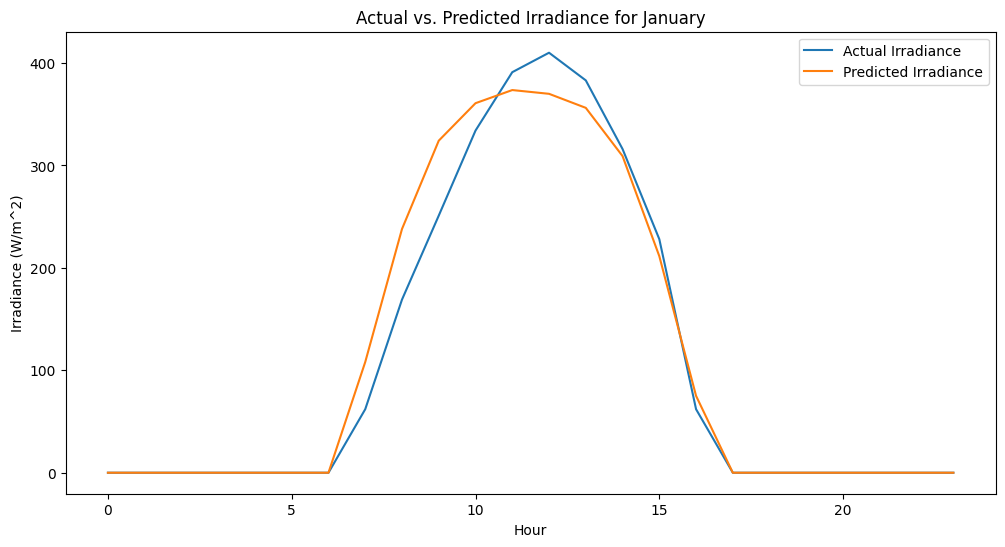

In [10]:
# Example usage: Predict the irradiance for July, hour 12 with additional features
month = 'January'
hour = 12
predicted_irradiance = predict_irradiance(month, hour, 28.570633, 77.327215, 500, 0.15, 6.43988, 17.7, 55)
print(f'Predicted irradiance for {month}, hour {hour}: {predicted_irradiance}')

# Plot Actual vs. Predicted Irradiance for a specific month
month = 'January'
actual_irradiance = get_actual_irradiance(month)
predicted_irradiances = []

for hour in range(24):
    irradiance = predict_irradiance(month, hour, 28.570633, 77.327215, 500, 0.15, 6.43988, 17.7, 55)
    predicted_irradiances.append(irradiance)

plt.figure(figsize=(12, 6))
plt.plot(range(24), actual_irradiance, label='Actual Irradiance')
plt.plot(range(24), predicted_irradiances, label='Predicted Irradiance')
plt.xlabel('Hour')
plt.ylabel('Irradiance (W/m^2)')
plt.title(f'Actual vs. Predicted Irradiance for {month}')
plt.legend()
plt.show()

In [ ]:
import pandas as pd

# Get unique months from the data
months = data['Month'].unique()

# Create a DataFrame to store the evaluation metrics
metrics_df = pd.DataFrame(columns=['Month', 'MSE', 'RMSE', 'MAE', 'R-squared'])

# Iterate over each month
for month in months:
    # Get the actual and predicted irradiance
    actual_irradiance = get_actual_irradiance(month)
    predicted_irradiance = []

    for hour in range(24):
        irradiance = predict_irradiance(month, hour, 28.570633, 77.327215, 500, 0.15, 6.43988, 17.7, 55)
        predicted_irradiance.append(irradiance)

    # Calculate evaluation metrics
    mse = mean_squared_error(actual_irradiance, predicted_irradiance)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_irradiance, predicted_irradiance)
    r2 = r2_score(actual_irradiance, predicted_irradiance)

    # Add the metrics to the DataFrame
    metrics_df = metrics_df.append({'Month': month, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R-squared': r2}, ignore_index=True)

# Display the evaluation metrics table
print(metrics_df)


In [ ]:
def plot_irradiance_scatter(month):
    actual_irradiance = get_actual_irradiance(month)
    predicted_irradiances = []

    for hour in range(24):
        irradiance = predict_irradiance(month, hour, 28.570633, 77.327215, 500, 0.15, 6.43988, 17.7, 55)
        predicted_irradiances.append(irradiance)

    # Scatter plot of Actual vs. Predicted Irradiance
    plt.figure(figsize=(8, 6))
    plt.scatter(range(24), actual_irradiance, label='Actual Irradiance', color='blue')
    plt.scatter(range(24), predicted_irradiances, label='Predicted Irradiance', color='red')
    plt.xlabel('Hour')
    plt.ylabel('Irradiance (W/m^2)')
    plt.title(f'Actual vs. Predicted Irradiance for {month}')
    plt.legend()
    plt.show()

# Example usage: Plot Actual vs. Predicted Irradiance as scatter plots for a specific month
month = 'august'
plot_irradiance_scatter(month)

In [ ]:
# Function to plot Hour vs. Irradiance for all months
def plot_hour_vs_irradiance():
    months = data['Month'].unique()
    hour_range = range(24)

    # Initialize arrays to store predicted and actual irradiance values
    predicted_irradiances = np.zeros((len(months), 24))
    actual_irradiances = np.zeros((len(months), 24))

    # Iterate over each month and hour to get predicted and actual irradiance
    for i, month in enumerate(months):
        for hour in hour_range:
            if hour in range(6) or hour in range(18, 24):
                irradiance = 0  # Set predicted irradiance to 0
            else:
                irradiance = predict_irradiance(month, hour, 28.570633, 77.327215, 500, 0.15, 6.43988, 17.7, 55)
            predicted_irradiances[i][hour] = irradiance
            actual_irradiances[i][hour] = get_actual_irradiance(month)[hour]

    # Plotting the bar plot
    bar_width = 0.35
    index = np.arange(len(hour_range))

    plt.figure(figsize=(12, 6))
    plt.bar(index, predicted_irradiances.mean(axis=0), bar_width, label='Predicted Irradiance')
    plt.bar(index + bar_width, actual_irradiances.mean(axis=0), bar_width, label='Actual Irradiance')

    plt.xlabel('Hour')
    plt.ylabel('Irradiance (W/m^2)')
    plt.title('Hour vs. Irradiance')
    plt.xticks(index + bar_width/2, hour_range)
    plt.legend()
    plt.show()

# Example usage: Plot Hour vs. Irradiance bar plot for all months
plot_hour_vs_irradiance()
